# **Nucleus detection parameter selection experiment**
**In this experiment there will be two steps.**
1. Run for a single image multipe parameter variations and get the most detections possible
2. Run the selected parameters and the deafault parameters and extract statistical data about the selected parameters in comparison to the deafault ones 

## **Step one multiple parameters single image**

### 1. **Import Required Libraries**

In this step, we import all the necessary libraries for file handling, logging, and running subprocesses. We also include `pandas` for handling the results in tabular form.

In [13]:
import os
import subprocess
import pandas as pd
import re
import logging
import sys
import json
import openslide
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

### 2. **Set Up Paths**

Set the paths for the input image directory, output directory, and other relevant parameters. In the flow itself theses paths are flags given to the function

In [3]:
image_dir = "/home/ilants/Documents/jupyter_test"
single_image_multiple_params_outdir = "/home/ilants/Documents/jupyter_test/single_image_multiple_params"
multiple_image_single_param = "/home/ilants/Documents/jupyter_test/multiple_image_single_param"
image_type = "svs"  
groovy_script = "/home/ilants/Documents/utls/nucleus_detection_wargs.groovy"
config_file = "/home/ilants/Documents/utls/qupath_parameters.json"
program_path = "/home/ilants/Documents/QuPath-v0.5.1-Linux/QuPath/bin/QuPath"

## 3. **Preview the JSON Configuration File**
The `json` configuration is with the deafult parameters that will be swaped for a list of values to check

In [4]:
# Load and display the JSON file
with open(config_file, 'r') as file:
    json_data = json.load(file)

# Pretty print the JSON content
print(json.dumps(json_data, indent=4)) 

{
    "detectionImageBrightfield": "Hematoxylin OD",
    "requestedPixelSizeMicrons": 0.5,
    "backgroundRadiusMicrons": 4.0,
    "backgroundByReconstruction": true,
    "medianRadiusMicrons": 0.0,
    "sigmaMicrons": 1.5,
    "minAreaMicrons": 10.0,
    "maxAreaMicrons": 80.0,
    "threshold": 0.1,
    "maxBackground": 2.0,
    "watershedPostProcess": true,
    "cellExpansionMicrons": 5.0,
    "includeNuclei": true,
    "smoothBoundaries": true,
    "makeMeasurements": true,
    "backgroundRadiusPixel": 8.0,
    "cellExpansionPixel": 10.0,
    "medianRadiusPixel": 0.0,
    "minAreaPixel": 20.0,
    "maxAreaPixel": 160.0
}


## 4. **Select parameters to itarate over**

In [1]:
experiment_parameters = {
    "requestedPixelSizeMicrons":[0, 0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5],
    "threshold":[0, 0.0025, 0.005, 0.01 ,0.025, 0.05, 0.075, 0.1, 0.125, 0.15],
    "backgroundRadiusMicrons":[2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0, 18.0, 20.0],
    "sigmaMicrons":[0, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.25],
    "minAreaMicrons":[5.0, 6.6, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0],
    "maxAreaMicrons":[20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 100.0, 110.0],
    "cellExpansionMicrons": [0.0, 1,0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0 ]
}

## 5. **Preview the image that will be examined**

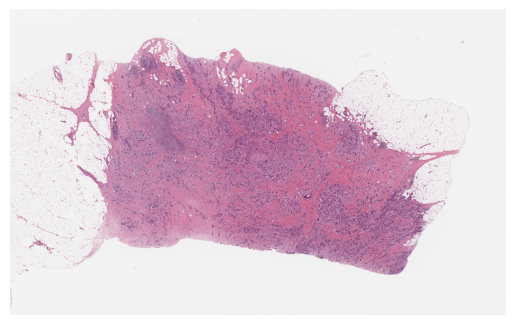

Dimensions: (63784, 39311)
Downsample levels: 3
Level dimensions: ((63784, 39311), (15946, 9827), (3986, 2456))


In [6]:
single_image_tested = [image for image in os.listdir(image_dir) if re.search(".svs", image)][0]
slide = openslide.OpenSlide(os.path.join(image_dir, single_image_tested))

# Get a thumbnail image for quick visualization (downsampled)
thumbnail = slide.get_thumbnail((1000, 1000))

# Display the thumbnail
plt.imshow(thumbnail)
plt.axis('off')
plt.show()

# Print some properties of the SVS file
print(f"Dimensions: {slide.dimensions}")
print(f"Downsample levels: {slide.level_count}")
print(f"Level dimensions: {slide.level_dimensions}")

## 5. **Define: Automated Image Analysis with QuPath**
This function `run_qupath_image_extraction` automates the process of analyzing images using QuPath, a bioimage analysis software. It sets up an output directory and logging, reads parameters from a configuration file, and runs a specified Groovy script through QuPath in a subprocess while capturing real-time output. After the subprocess completes, it processes the generated TSV files to compute averages of numerical data, such as cell detection metrics, across all images. Finally, it compiles these averages into a summary table and saves it as a CSV file in the output directory, providing a consolidated view of the analysis results.

In [5]:
def run_qupath_image_extraction(image_dir, output_dir=None, image_type='svs', groovy_script="qupath_script.groovy", config_file='qupath_parameters.json', program_path="QuPath-0.5.1 (console).exe"):
    """
    Automates the process of analyzing images using QuPath, a bioimage analysis software.

    Parameters:
    - image_dir (str): Directory containing the images to be analyzed.
    - output_dir (str, optional): Directory where the output will be saved. Defaults to 'qupath_output/' within the image directory.
    - image_type (str, optional): Type of image files to process (e.g., 'svs'). Defaults to 'svs'.
    - groovy_script (str, optional): Path to the Groovy script to be executed by QuPath. Defaults to "qupath_script.groovy".
    - config_file (str, optional): Path to the configuration file with QuPath parameters. Defaults to 'qupath_parameters.json'.
    - program_path (str, optional): Path to the QuPath executable. Defaults to "QuPath-0.5.1 (console).exe".

    The function performs the following steps:
    1. Sets up the output directory and logging configuration.
    2. Reads parameters from the configuration file.
    3. Runs the specified Groovy script in a subprocess while capturing real-time output.
    4. Processes generated TSV files to compute averages of numerical data across all images.
    5. Compiles these averages into a summary table and saves it as a CSV file in the output directory.

    Returns:
    None
    """
    if output_dir is None:
        output_dir = os.path.join(image_dir, "qupath_output/")
    if not os.path.isdir(output_dir):
        os.mkdir(output_dir)

    # Set up logging
    logging.basicConfig(filename=os.path.join(output_dir, 'qupath_image_extraction.log'), level=logging.INFO, format='%(asctime)s %(levelname)s: %(message)s', datefmt='%Y-%m-%d %H:%M:%S')

    logging.info(f"Starting QuPath image extraction with the following parameters: image_dir={image_dir}, output_dir={output_dir}, image_type={image_type}, groovy_script={groovy_script}, config_file={config_file}, program_path={program_path}")

    qupath_parameters = ""
    with open(config_file) as fs:
        for line in fs:
            qupath_parameters += line.strip()
    # qupath_parameters = qupath_parameters.replace(" ", "____")
    
    # Run the subprocess with real-time output
    process = subprocess.Popen([program_path, "script", groovy_script, "-a", image_dir, "-a", output_dir, "-a", qupath_parameters, "-a", image_type], 
                               stdout=subprocess.PIPE, 
                               stderr=subprocess.STDOUT,
                               universal_newlines=True,
                               bufsize=1)

    # Print and log output in real-time
    for line in iter(process.stdout.readline, ''):
        print(line, end='')  
        logging.info(line.strip())  
        sys.stdout.flush()  

    process.stdout.close()
    return_code = process.wait()

    if return_code:
        logging.error(f"Subprocess returned non-zero exit code: {return_code}")
        raise subprocess.CalledProcessError(return_code, process.args)

    logging.info("QuPath subprocess completed.")

    average_all = pd.DataFrame([])
    for file in os.listdir(os.path.join(output_dir, "QPProject")):
        if file.endswith('.tsv'):
            print(f"Processing image: {file}")
            df = pd.read_csv(os.path.join(output_dir, "QPProject", file), sep='\t')
            # transform headers to original format
            df.columns = [re.sub(r' ', '', col) for col in df.columns]
            df.columns = [re.sub(r'[\(\)\:\.]', '_', col) for col in df.columns]

            image = df.iloc[0, 0]
            numbers = df.iloc[:, 7:]
            average = numbers.mean(axis=0, skipna=False)
            df_average = pd.DataFrame([average])
            df_average.insert(0, 'Image', image)
            average_all = pd.concat([average_all, df_average])
            print(f"Finished processing image: {file}")

    summary_table_path = os.path.join(output_dir, "Summary_Table.csv")
    average_all.to_csv(summary_table_path)

    logging.info(f"QuPath image extraction completed successfully. Output directory: {output_dir}")
    logging.info(f"Summary table saved to: {summary_table_path}")
    print(f"QuPath image extraction completed successfully. Output directory: {output_dir}")
    print(f"Summary table saved to: {summary_table_path}")


## **6. Multiple Parameter Single Image Experiment**

The function `multiple_params_single_image_exp` automates the execution of multiple experiments on a set of images by systematically varying specified parameters. It takes an output directory, input image directory, image type, paths to necessary scripts and configurations, and a dictionary of experiment parameters. This function streamlines the process of testing multiple configurations, making it efficient to evaluate how different parameter values affect the image analysis results using QuPath.

In [6]:
def multiple_params_single_image_exp(outdir,input_image_dir, image_type, nucleus_detection_automation, qupath_console_path, cfg, experiment_parameters):
    """
    Executes multiple image analysis experiments by varying specified parameters using QuPath.

    Parameters:
    - outdir (str): The base output directory where experiment results will be saved.
    - input_image_dir (str): Directory containing the images to be analyzed.
    - image_type (str): Type of image files to process (e.g., 'svs').
    - nucleus_detection_automation (str): Path to the Groovy script for nucleus detection automation.
    - qupath_console_path (str): Path to the QuPath console executable.
    - cfg (dict): Base configuration parameters for QuPath.
    - experiment_parameters (dict): Dictionary where keys are parameter names to vary, and values are lists of parameter values to test.

    The function performs the following steps:
    1. Iterates over each parameter and its list of values specified in `experiment_parameters`.
    2. For each parameter value:
       - Creates a unique output directory named using the parameter and its value.
       - Copies the base configuration and updates it with the new parameter value.
       - Saves the updated configuration as `cfg.json` in the experiment's output directory.
       - Sets up a separate log file for the experiment.
       - Logs the start of the experiment and the configuration used.
       - Calls `run_qupath_image_extraction` to perform image analysis with the updated configuration.
       - Handles and logs any errors that occur during execution.
       - Shuts down logging to ensure logs are properly saved before the next experiment.
    3. After all experiments are completed, prints a summary of the parameters tested and the location of the results.

    Returns:
    None
    """
    for param in experiment_parameters.keys():
        exp_tmp_cfg = cfg.copy()
        for value in experiment_parameters[param]:
            exp_outdir = os.path.join(outdir, f"exp_{param}_{value}")
            print(exp_outdir)
            os.makedirs(exp_outdir, exist_ok=True)

            exp_json = os.path.join(exp_outdir, "cfg.json")
            exp_tmp_cfg[param] = value
            with open(exp_json, "w") as exp_cfg_file:
                json.dump(exp_tmp_cfg, exp_cfg_file, indent=4)


            # Set up a separate log file for each experiment
            log_file = os.path.join(exp_outdir, 'experiment.log')
            logging.basicConfig(
                filename=log_file, 
                level=logging.INFO, 
                format='%(asctime)s %(levelname)s: %(message)s', 
                datefmt='%Y-%m-%d %H:%M:%S',
                force=True  # Ensures that the logging configuration is updated
            )

            logging.info(f"Starting experiment with for {param} with value of {value}")
            logging.info(f"Running with the following configuration:\n{exp_tmp_cfg}")
            
            try:
                run_qupath_image_extraction(
                    input_image_dir, exp_outdir, image_type, 
                    nucleus_detection_automation, exp_json, qupath_console_path
                )
                logging.info("Experiment completed successfully.")
            except subprocess.CalledProcessError as e:
                logging.error(f"Experiment failed with error: {e}")
            
            # Ensure the log is closed properly before starting the next experiment
            logging.shutdown()
        

    print(f"Run completed for:")
    print(experiment_parameters)
    print(f"Results are in: {exp_outdir}") 



In [24]:
multiple_params_single_image_exp(single_image_multiple_params_outdir, image_dir, image_type, groovy_script, program_path, json_data, experiment_parameters)

AttributeError: 'str' object has no attribute 'write'

## 7. Plot Detection vs Parameter
The function `plot_detection_vs_param` visualizes how the number of cells detected varies with different parameter values across multiple experiments. It processes the results from experiments that have systematically varied parameters and generates plots to illustrate the impact of each parameter on cell detection.

**Note**: The function assumes that the experiment directories are named following the pattern `exp_[parameter_name]_[parameter_value]`, and that each experiment directory contains a `Summary_Table.csv` file with a `"Clustersize"` column.

In [4]:
def plot_detection_vs_param(single_image_multiple_params_outdir):
    """
    Plots the relationship between the number of cells detected and varying parameter values from multiple experiments.

    Parameters:
    - single_image_multiple_params_outdir (str): The directory containing the results of experiments where parameters were varied.
    
    The function performs the following steps:
    1. Aggregates data from multiple experiment directories within the specified output directory.
    2. Extracts parameter names and values from the experiment directory names (assumes naming convention 'exp_paramName_value').
    3. Reads the number of cells detected from the 'Summary_Table.csv' file in each experiment directory, specifically from the 'Clustersize' column.
    4. Organizes the data into a dictionary mapping each parameter to its corresponding data points (parameter value and cells detected).
    5. Sorts the data points for each parameter based on the parameter values to ensure the plots are accurate.
    6. Plots the number of cells detected against the parameter values for each parameter using Matplotlib.
    
    Returns:
    None

    Note:
    - Assumes that each experiment directory is named in the format 'exp_paramName_value'.
    - Assumes that each 'Summary_Table.csv' contains a column named 'Clustersize'.
    """
    experiments2graphs = {}
    
    # Collect data from experiments
    for experiment in os.listdir(single_image_multiple_params_outdir):
        exp_lst = experiment.split("_")
        param_name = exp_lst[1]
        
        # Initialize list for each unique parameter
        if param_name not in experiments2graphs:
            experiments2graphs[param_name] = []
        
        # Read the number of cells detected from Summary_Table.csv
        cells_detected = pd.read_csv(os.path.join(single_image_multiple_params_outdir, experiment, "Summary_Table.csv"))["Clustersize"].iloc[0]
        numOfDetections2paramValue = (float(exp_lst[2]), float(cells_detected))
        experiments2graphs[param_name].append(numOfDetections2paramValue)
    
    # Plot results for each parameter
    for parameter, data_points in experiments2graphs.items():
        sorted_data = sorted(data_points, key=lambda x: x[0])
        all_detections = [point[0] for point in sorted_data]
        all_param_values = [point[1] for point in sorted_data]
        
        plt.plot(all_detections, all_param_values, marker='o', linestyle='-', color='b')
        plt.xlabel(parameter)
        plt.ylabel("Number of Cells Detected")
        plt.title(f"Number of Cells Detected vs {parameter}")
        plt.grid(True)
        plt.show()

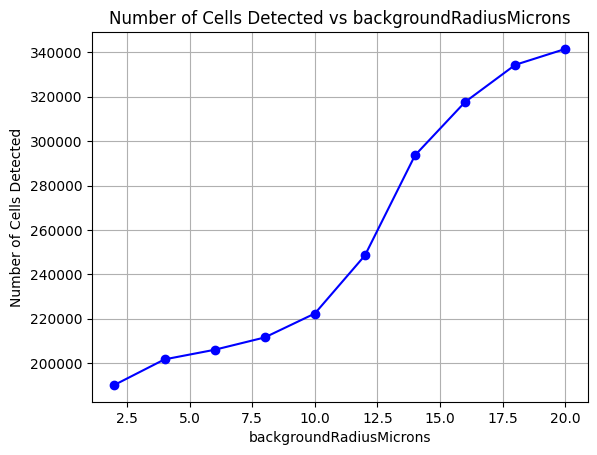

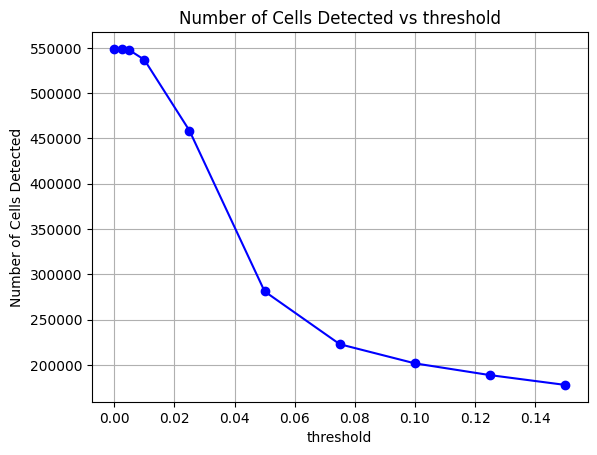

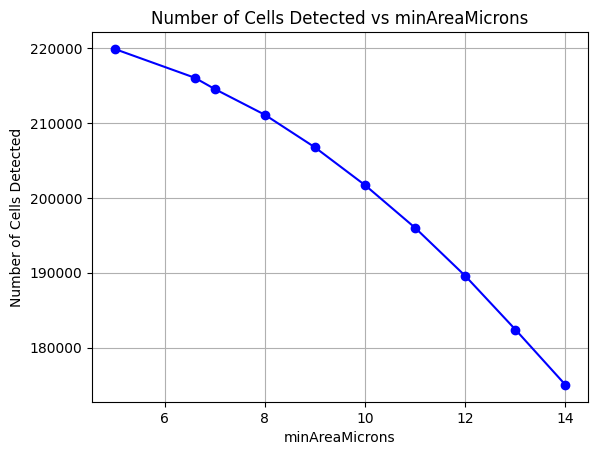

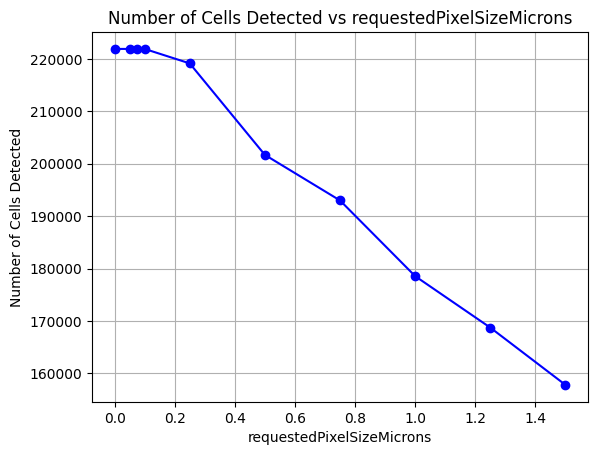

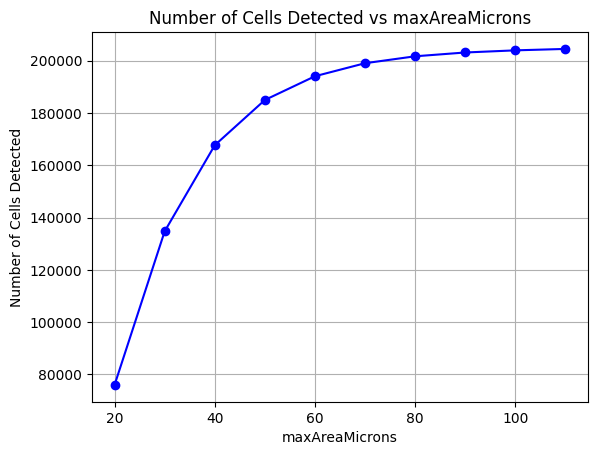

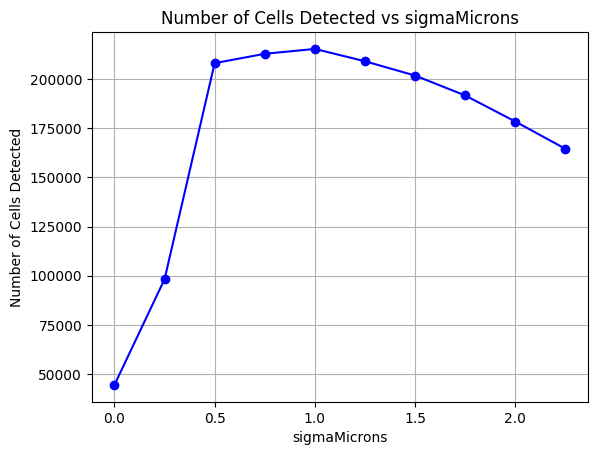

In [7]:
plot_detection_vs_param(single_image_multiple_params_outdir)


---
## 8. **Multi-Image Single Parameters Experiment Setup and Execution**

This code snippet sets up and executes an image analysis experiment on multiple images using optimized parameters with the `run_qupath_image_extraction` function. This code automates the process of running an image analysis experiment on multiple images using a set of optimized parameters. It ensures that the configuration is correctly set up and saved before execution, allowing for consistent and reproducible analysis across all images in the specified directory.

In [8]:
multi_image_dir = "/home/ilants/Documents/multi_image_single_set_params_run"
# os.mkdir(multiple_image_single_param)
exp_json = os.path.join(multiple_image_single_param, "cfg.json")
exp_tmp_cfg = json_data.copy()
optimized_experiment_parameters = {
    "requestedPixelSizeMicrons":0.05,
    "threshold":0.005,
    "sigmaMicrons":1,
    "maxAreaMicrons":100.0,
}
for parameter in optimized_experiment_parameters.keys(): 
    exp_tmp_cfg[parameter] = optimized_experiment_parameters[parameter]
print("Multi image experiment parameters")
print(json.dumps(exp_tmp_cfg, indent=4)) 

with open(exp_json, "w") as exp_cfg_file:
    json.dump(exp_tmp_cfg, exp_cfg_file, indent=4)
run_qupath_image_extraction(multi_image_dir, multiple_image_single_param, image_type, groovy_script, exp_json, program_path)

Multi image experiment parameters
{
    "detectionImageBrightfield": "Hematoxylin OD",
    "requestedPixelSizeMicrons": 0.05,
    "backgroundRadiusMicrons": 4.0,
    "backgroundByReconstruction": true,
    "medianRadiusMicrons": 0.0,
    "sigmaMicrons": 1,
    "minAreaMicrons": 10.0,
    "maxAreaMicrons": 100.0,
    "threshold": 0.005,
    "maxBackground": 2.0,
    "watershedPostProcess": true,
    "cellExpansionMicrons": 5.0,
    "includeNuclei": true,
    "smoothBoundaries": true,
    "makeMeasurements": true,
    "backgroundRadiusPixel": 8.0,
    "cellExpansionPixel": 10.0,
    "medianRadiusPixel": 0.0,
    "minAreaPixel": 20.0,
    "maxAreaPixel": 160.0
}
19:30:14.336 [main] [INFO ] qupath.lib.gui.prefs.PathPrefs - Setting default Locale to en_US
19:30:14.339 [main] [INFO ] qupath.lib.gui.prefs.PathPrefs - Setting Locale for FORMAT to en_US
19:30:14.339 [main] [INFO ] qupath.lib.gui.prefs.PathPrefs - Setting Locale for DISPLAY to en_US
19:30:14.353 [main] [INFO ] qupath.lib.common.

## **Plot Cluster Size (number of cells detected) with Error Bars**

The function `plot_clustersize_with_error` visualizes the cluster size data, specifically the number of cells detected, with symmetric error bars. It allows for comparison between data collected 'after optimization' and 'before optimization' to assess the impact of optimization on cell detection. This function is useful for visualizing the effect of optimization on the number of cells detected in image analysis. It provides a clear visual representation of how Clustersize values change before and after optimization. The error bars help in understanding the variability or uncertainty associated with the Clustersize measurements. Adjusting the `error_factor` allows for scaling the error bars appropriately. By plotting both datasets on the same graph, it facilitates direct comparison to assess the effectiveness of optimization parameters.

**Additional Notes**:

- The function assumes that the DataFrames `data_after` and `data_before` contain at least the columns specified by `param_to_eval` (default 'Clustersize') and 'Image'.
- The `error_factor` can be adjusted to reflect the desired confidence interval or variability in the data.
- The asymmetric error plotting section is commented out; you can uncomment and adjust it if asymmetric error representation is needed.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import f_oneway

def plot_clustersize_with_error(data_after, data_before=None, error_factor=0.1, param_to_eval='Clustersize'):
    """
    Plots Clustersize data with symmetric error bars,
    comparing 'after optimization' (data_after) with 'before optimization' (data_before),
    and plots p-values using ANOVA test.
    
    Parameters:
    - data_after (DataFrame): DataFrame containing 'Clustersize' and 'Image' columns (after optimization).
    - data_before (DataFrame, optional): DataFrame for comparison (before optimization).
    - error_factor (float): Factor to calculate error bars relative to Clustersize values.
    """
    # Extract Clustersize data and Image labels for data_after (after optimization)
    clustersize_after = data_after[param_to_eval].values
    x_labels_after = data_after['Image'].values  # Image labels for x-axis
    x_after = np.arange(len(clustersize_after))  # Numeric indices for plotting

    # Calculate symmetric and asymmetric error for data_after
    error_after = error_factor * clustersize_after
    lower_error_after = 0.4 * error_after
    upper_error_after = error_after
    asymmetric_error_after = [lower_error_after, upper_error_after]
    
    # Set up data_before (before optimization) if provided
    if data_before is not None:
        clustersize_before = data_before[param_to_eval].values
        x_labels_before = data_before['Image'].values
        x_before = np.arange(len(clustersize_before))
        error_before = error_factor * clustersize_before
        lower_error_before = 0.4 * error_before
        upper_error_before = error_before
        asymmetric_error_before = [lower_error_before, upper_error_before]
        
        # Calculate and print the percentage increase in average cluster size
        avg_after = np.mean(clustersize_after)
        avg_before = np.mean(clustersize_before)
        percentage_increase = ((avg_after - avg_before) / avg_before) * 100
        print(f"Average cluster size increased by {percentage_increase:.2f}% after optimization.")
        
        # Perform ANOVA test and plot p-values
        _, p_value = f_oneway(clustersize_after, clustersize_before)
        print(f"ANOVA p-value: {p_value:.5f}")
        
        # Plot the p-value result
        plt.figure(figsize=(8, 6))  # Adjust figure size for better readability
        plt.bar(['ANOVA p-value'], [p_value], color='skyblue', width=0.6)
        plt.ylim(0, 1)
        plt.axhline(0.05, color='red', linestyle='--', linewidth=1.5, label='Significance Level (0.05)')
        plt.text(0, p_value + 0.05, f'p = {p_value:.5f}', ha='center', color='purple', fontsize=12, fontweight='bold')
        plt.title('ANOVA Test for Clustersize Comparison', fontsize=14)
        plt.ylabel('p-value', fontsize=12)
        plt.xlabel("Feature", fontsize=12)
        plt.xticks(fontsize=12, rotation=0)
        plt.yticks(fontsize=12)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.legend(fontsize=10)
        plt.tight_layout()
        plt.show()
    
    # Plot with symmetric error
    plt.figure(figsize=(18, 8))
    plt.errorbar(x_after, clustersize_after, yerr=error_after, fmt='-o', color='blue', label='After Optimization')
    if data_before is not None:
        plt.errorbar(x_before, clustersize_before, yerr=error_before, fmt='-o', color='orange', label='Before Optimization')
    plt.title('Clustersize (Number of cells detected) with Symmetric Error Bars (After vs. Before Optimization)')
    plt.xlabel('Image')
    plt.ylabel('Clustersize')
    plt.xticks(ticks=x_after, labels=x_labels_after, rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()


Average cluster size increased by 84.99% after optimization.
ANOVA p-value: 0.03647


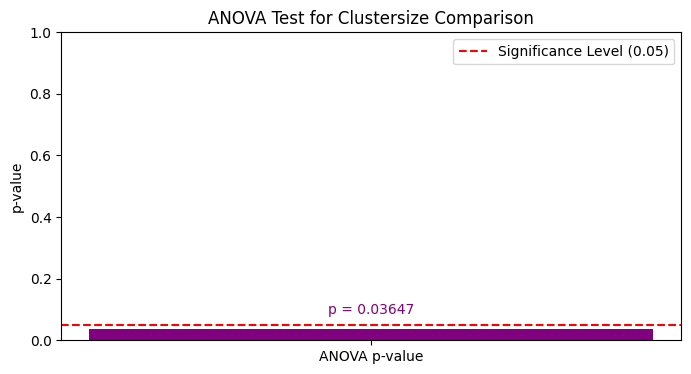

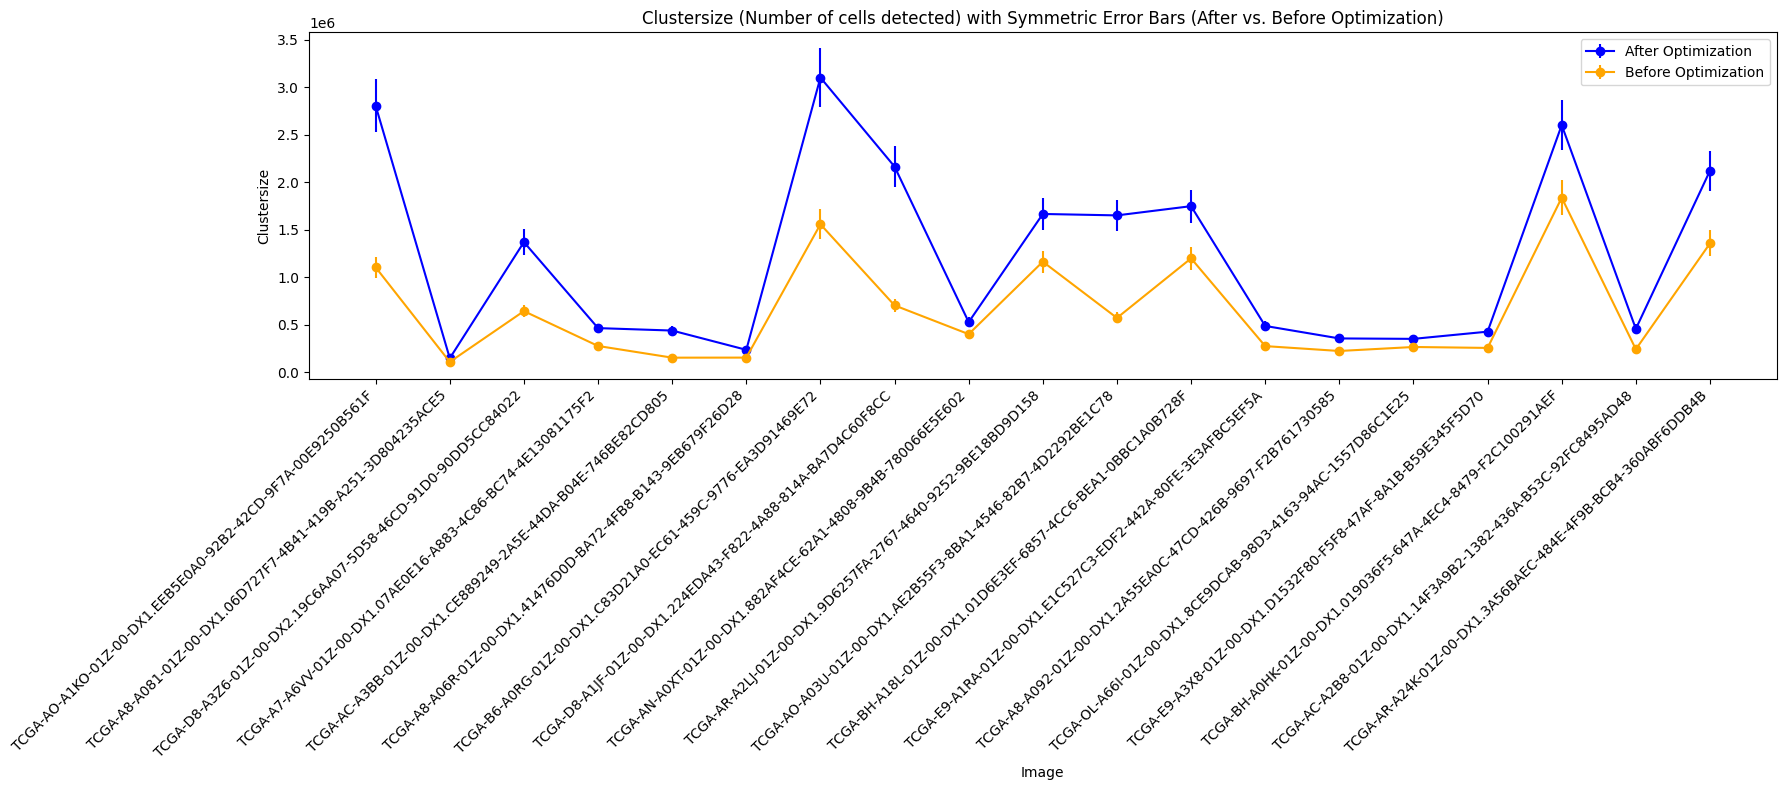

In [2]:
plot_clustersize_with_error(pd.read_csv("/home/ilants/Documents/jupyter_test/multiple_image_single_param/Summary_Table.csv"), pd.read_csv("/home/ilants/Documents/multi_image_single_set_params_run/Summary_Table.csv"))

NameError: name 'clustersize_after' is not defined